# Course 2 Project: ML Pipeline for Feature Engineering

## Instructions

In this project, you'll use data related to microeconomic indicators and historical stock prices to explore the data engineering pipline. You'll get to practice:

* Data ingestion 
* Data cleaning
* Data imputation
* Exploratory data analysis (EDA) through charts and graphs

## Packages

You'll use `pandas` and `matplotlib`, which were covered in the course material, to import, clean, and plot data. They have been installed in this workspace for you. If you're working locally and you installed Jupyter using Anaconda, these packages will already be installed. 

In [17]:

!pip install seaborn



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

The first step in a data engineering pipeline for machine learning is to ingest the data that will be used. For this project, data is hosted on a public GitHub repo. 

### Your tasks
* Import data from the provided [GitHub repo](https://github.com/udacity/CD13649-Project/tree/main/Project) using `pandas`. For your convenience, the data files (CSVs) are also present in the current workspace at the path **CD13649-Project/Project/**. Here are the data files to import: 
  1. GDP (**GDP.csv**)
  2. Inflation (**inflation_monthly.csv**)
  3. Apple stock prices (**apple_historical_data.csv**)
  4. Microsoft stock prices (**microsoft_historical_data.csv**)
  5. Consumer price index (**consumer_price_index.csv**)



* Verify that the data has been imported correctly into `pandas` dataframes. Use methods like `head()` and `info()`


* You may need to change column names to make them easier to work with


* You may need to cast datetime data to the `datetime` format using `pandas` `to_datetime()` method



In [19]:
# Load historical GDP data

gdp_df = pd.read_csv('GDP.csv')

In [20]:
# Check the first few rows of data
gdp_df.head()


,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [21]:
# Load the historical stock price data for Apple and Microsoft
msft_df = pd.read_csv('microsoft_historical_data.csv')
aapl_df = pd.read_csv('apple_historical_data.csv')

In [22]:
#Before I proceed, I observed that the stock data are in the reverse order. This may raise issues in calculating the returns and
#many other metrics. Therefore I reverse the order of the data before proceeding
#First convert the text dates to actual dates
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
msft_df['Date'] = pd.to_datetime(msft_df['Date'])
#set the index
aapl_df.set_index('Date', inplace=True)
msft_df.set_index('Date', inplace=True)
#redefine the datasets with proper order
aapl_df = aapl_df.sort_index()
aapl_df = aapl_df.copy()
msft_df = msft_df.sort_index()
msft_df = msft_df.copy()

In [23]:
#Sanity check
#aapl_df
#msft_df

In [24]:
# Check the first few rows of data
msft_df.head()

#aapl_df.describe()
#gdp_df.info()
#gdp_df.describe()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-06,$39.06,27105700,$39.29,$39.35,$38.95
2014-05-07,$39.425,41731030,$39.22,$39.51,$38.51
2014-05-08,$39.64,32089010,$39.34,$39.90,$38.97
2014-05-09,$39.54,29646100,$39.54,$39.85,$39.37
2014-05-12,$39.97,22761620,$39.74,$40.02,$39.65


In [25]:
aapl_df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-06,$21.23,373872650,$21.49,$21.59,$21.23
2014-05-07,$21.15,282128727,$21.26,$21.33,$20.99
2014-05-08,$21.00,228973884,$21.01,$21.23,$20.94
2014-05-09,$20.91,291068564,$20.88,$20.94,$20.73
2014-05-12,$21.17,212736019,$20.98,$21.20,$20.98


In [26]:
# Use methods like .info() and .describe() to explore the data
#msft_df.info()
msft_df.describe()


#aapl_df.head()
#msft_df.head()

,Volume
count,2.517000e+03
mean,2.953106e+07
std,1.370138e+07
min,7.425603e+06
25%,2.131892e+07
50%,2.639470e+07
75%,3.360003e+07
max,2.025141e+08


In [27]:
msft_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-05-06 to 2024-05-03
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Close/Last  2517 non-null   object
 1   Volume      2517 non-null   int64 
 2   Open        2517 non-null   object
 3   High        2517 non-null   object
 4   Low         2517 non-null   object
dtypes: int64(1), object(4)
memory usage: 118.0+ KB


In [28]:
aapl_df.describe()

,Volume
count,2.517000e+03
mean,1.277394e+08
std,7.357405e+07
min,2.404834e+07
25%,7.741776e+07
50%,1.077601e+08
75%,1.567789e+08
max,7.576780e+08


In [29]:
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-05-06 to 2024-05-03
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Close/Last  2514 non-null   object
 1   Volume      2517 non-null   int64 
 2   Open        2517 non-null   object
 3   High        2517 non-null   object
 4   Low         2517 non-null   object
dtypes: int64(1), object(4)
memory usage: 118.0+ KB


## Data preprocessing: Check for missing data and forward fill

Check the Apple historical prices for missing data. Check for missing data in all columns. If there's data missing, use a forward fill to fill in those missing prices. 

In [30]:
# Check for nulls 
aapl_df.isnull().any()


Close/Last     True
Volume        False
Open          False
High          False
Low           False
dtype: bool

In [31]:
msft_df.isnull().any()

Close/Last    False
Volume        False
Open          False
High          False
Low           False
dtype: bool

In [32]:
#aapl_df is the only dataframe with missing data.
#As requested by the submission, here follows a detailed report with the 
print("Number of missing values per column:")
print(aapl_df.isnull().sum())

Number of missing values per column:
Close/Last    3
Volume        0
Open          0
High          0
Low           0
dtype: int64


In [33]:
#idenfity the records with missing values
null_rows = aapl_df[aapl_df.isnull().any(axis=1)]
print("Rows with at least one missing value:")
print(null_rows)

Rows with at least one missing value:
           Close/Last    Volume      Open      High       Low
Date                                                         
2023-11-20        NaN  46538610  $189.89   $191.91   $189.88 
2024-01-26        NaN  44594010  $194.27   $194.76   $191.94 
2024-04-08        NaN  37425510  $169.03   $169.20   $168.24 


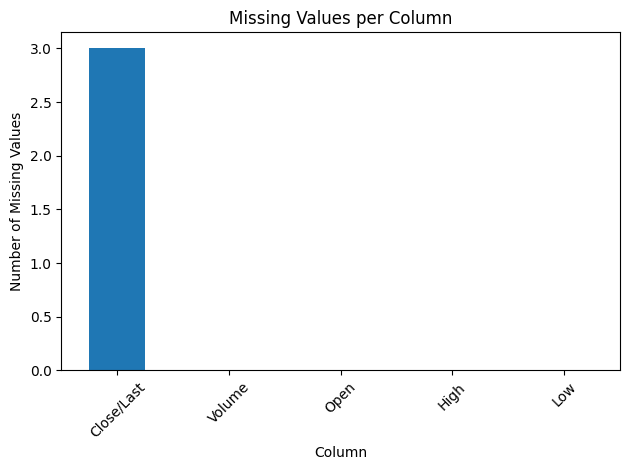

In [34]:
#Further analysis recarding the missing values
#A Picture speaks a thousand words
import matplotlib.pyplot as plt

# Calculate missing values
missing_counts = aapl_df.isnull().sum()

# Plot
missing_counts.plot(kind='bar')
plt.title('Missing Values per Column')
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Forward fill any missing data
aapl_df.ffill(inplace=True)

In [36]:
#checking null values have been dealt with
aapl_df.isnull().any()

Close/Last    False
Volume        False
Open          False
High          False
Low           False
dtype: bool

## Data preprocessing: Remove special characters and convert to numeric/datetime

The next step in the data engineering process is to standardize and clean up data. In this step, you'll check for odd formatting and special characters that will make it difficult to work with data as numeric or datetime. 

In this step:
* Create a function that takes in a dataframe and a list of columns and removes dollar signs ('$') from those columns
* Convert any columns with date/time data into a `pandas` `datetime` format

In [37]:
aapl_df


,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-06,$21.23,373872650,$21.49,$21.59,$21.23
2014-05-07,$21.15,282128727,$21.26,$21.33,$20.99
2014-05-08,$21.00,228973884,$21.01,$21.23,$20.94
2014-05-09,$20.91,291068564,$20.88,$20.94,$20.73
2014-05-12,$21.17,212736019,$20.98,$21.20,$20.98
...,...,...,...,...,...
2024-04-29,$173.50,68169420,$173.37,$176.03,$173.10
2024-04-30,$170.33,65934780,$173.33,$174.99,$170.00
2024-05-01,$169.30,50383150,$169.58,$172.71,$169.11


In [38]:
def convert_dollar_columns_to_numeric(df, numeric_columns):
    '''
        Removes dollar signs ('$') from a list of columns in a given dataframe AND casts the columns to a numeric datatype.
        Updates dataframe IN PLACE.
        
        Inputs:
            df: dataframe to be operated on
            numeric_columns: columns that should have numeric data but have dollar signs currently
            
        Returns:
            None - changes to the dataframe can be made in place
    '''
    for col in numeric_columns:
        df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)
    


<>:14: SyntaxWarning: invalid escape sequence '\$'
<>:14: SyntaxWarning: invalid escape sequence '\$'
C:\Users\mfabr\AppData\Local\Temp\ipykernel_7912\3767101423.py:14: SyntaxWarning: invalid escape sequence '\$'
  df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)


In [39]:
# Use convert_dollar_columns_to_numeric() to remove the dollar sign from the Apple and Microsoft datasets
numeric_columns = ['Close/Last', 'Open', 'High', 'Low']
#aapl_df
#msft_df
convert_dollar_columns_to_numeric(aapl_df, numeric_columns)
convert_dollar_columns_to_numeric(msft_df, numeric_columns)

#aapl_df.head()
msft_df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-05-06,39.060,27105700,39.29,39.35,38.95
2014-05-07,39.425,41731030,39.22,39.51,38.51
2014-05-08,39.640,32089010,39.34,39.90,38.97
2014-05-09,39.540,29646100,39.54,39.85,39.37
2014-05-12,39.970,22761620,39.74,40.02,39.65


In [40]:
# Use pandas's to_datetime() to convert any columns that are in a datetime format
msft_df = msft_df.reset_index()
aapl_df = aapl_df.reset_index()

msft_df['Date'] = pd.to_datetime(msft_df['Date'])
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])



In [41]:
aapl_df.head()


,Date,Close/Last,Volume,Open,High,Low
0,2014-05-06,21.23,373872650,21.49,21.59,21.23
1,2014-05-07,21.15,282128727,21.26,21.33,20.99
2,2014-05-08,21.00,228973884,21.01,21.23,20.94
3,2014-05-09,20.91,291068564,20.88,20.94,20.73
4,2014-05-12,21.17,212736019,20.98,21.20,20.98


In [42]:
#checking the effects of the date transformation
msft_df.head()
#aapl_df.head()


,Date,Close/Last,Volume,Open,High,Low
0,2014-05-06,39.060,27105700,39.29,39.35,38.95
1,2014-05-07,39.425,41731030,39.22,39.51,38.51
2,2014-05-08,39.640,32089010,39.34,39.90,38.97
3,2014-05-09,39.540,29646100,39.54,39.85,39.37
4,2014-05-12,39.970,22761620,39.74,40.02,39.65


In [43]:
# Use .info() and check the type of each column to ensure that the above steps worked
msft_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2517 non-null   datetime64[ns]
 1   Close/Last  2517 non-null   float64       
 2   Volume      2517 non-null   int64         
 3   Open        2517 non-null   float64       
 4   High        2517 non-null   float64       
 5   Low         2517 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


In [44]:
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2517 non-null   datetime64[ns]
 1   Close/Last  2517 non-null   float64       
 2   Volume      2517 non-null   int64         
 3   Open        2517 non-null   float64       
 4   High        2517 non-null   float64       
 5   Low         2517 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


## Data preprocessing: Align datetime data

Data engineering includes changing data with a datetime component if needed so that different time series can be more easily compared or plotted against each other. 

In this step:

* Align the inflation date so that it falls on the last day of the month instead of the first

Helpful hints: 
* Use the `pandas` `offsets` method using `MonthEnd(0)` to set the 'Date' column to month-end

In [45]:
# Align inflation data so that the date is the month end (e.g. Jan 31, Feb 28/28)
inflation_df = pd.read_csv('inflation_monthly.csv')
#inflation_df['Date'] = pd.to_datetime(inflation_df['Date'])



In [46]:
inflation_df['DATE'] = pd.to_datetime(inflation_df['DATE'])
inflation_df['DATE'] = inflation_df['DATE'] + pd.offsets.MonthEnd(0)

In [47]:
inflation_df.isnull().any()
#inflation_df.info()

DATE                    False
CORESTICKM159SFRBATL    False
dtype: bool

In [48]:
inflation_df

,DATE,CORESTICKM159SFRBATL
0,1968-01-31,3.651861
1,1968-02-29,3.673819
2,1968-03-31,4.142164
3,1968-04-30,4.155828
4,1968-05-31,4.088245
...,...,...
670,2023-11-30,4.688293
671,2023-12-31,4.554396
672,2024-01-31,4.603922
673,2024-02-29,4.403102


## Data preprocessing: Upsample, downsample and interpolate data

Inflation data is presented monthly in this dataset. However, for some models, you may need it at a quarterly frequency, and for some models you may need it at a quarterly frequency. 

In this step:
* Create a new quarterly inflation dataframe by downsampling the monthly inflation data to quarterly using the mean (e.g. for quarter 1 in a given year, use the average values from January, February, and March)
* Create a new weekly inflation dataframe by upsampling the monthly inflation data. For this, you'll need to use `resample` and then you'll need to `interpolate` to fill in the missing data at the weekly frequency

Note that you may need to change the index for some of these operations! 

In [49]:
#Preparatory step, make sure the date is the index of the DataFrame
inflation_df['DATE'] = pd.to_datetime(inflation_df['DATE'])  # Just in case
inflation_df.set_index('DATE', inplace=True)

In [50]:
# Upsample and interpolate from monthly to weekly 
inflation_weekly = inflation_df.resample('W').interpolate(method='linear')



In [51]:
# Downsample from monthly to quarterly 
inflation_quarterly = inflation_df.resample('Q').mean()


C:\Users\mfabr\AppData\Local\Temp\ipykernel_7912\994643945.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  inflation_quarterly = inflation_df.resample('Q').mean()


In [52]:
#inflation_quarterly
inflation_df

,CORESTICKM159SFRBATL
DATE,
1968-01-31,3.651861
1968-02-29,3.673819
1968-03-31,4.142164
1968-04-30,4.155828
1968-05-31,4.088245
...,...
2023-11-30,4.688293
2023-12-31,4.554396
2024-01-31,4.603922


In [53]:
inflation_quarterly

,CORESTICKM159SFRBATL
DATE,
1968-03-31,3.822615
1968-06-30,4.263214
1968-09-30,4.882643
1968-12-31,5.429443
1969-03-31,5.873770
...,...
2023-03-31,6.467833
2023-06-30,5.942054
2023-09-30,5.179249


## Data preprocessing: Normalize/standardize a feature

Economic time series data often involve variables measured on different scales (e.g., GDP in trillions of dollars, inflation in percentage points). Standardizing these variables (typically by subtracting the mean and dividing by the standard deviation) puts them on a common scale, allowing for meaningful comparisons and analyses.

Your task:
* Standardize the GDP data. You may do this manually by subtracting the mean and dividing by the standard deviation, or you may use a built-in method from a library like `sklearn`'s `StandardScaler`

In [54]:
# Standardize the GDP measure
#df_gdp['GDP_standardized'] = (df_gdp['GDP'] - df_gdp['GDP'].mean()) / df_gdp['GDP'].std()
gdp_df['GDP_standardized_home_made'] = (gdp_df['GDP'] - gdp_df['GDP'].mean()) / gdp_df['GDP'].std()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
gdp_df['GDP_standardized'] = scaler.fit_transform(gdp_df[['GDP']])



In [55]:
# Check the dataframe to make sure the calculation worked as expected 
gdp_df


,DATE,GDP,GDP_standardized_home_made,GDP_standardized
0,1947-01-01,243.164,-0.933981,-0.935496
1,1947-04-01,245.968,-0.933606,-0.935121
2,1947-07-01,249.585,-0.933123,-0.934636
3,1947-10-01,259.745,-0.931764,-0.933276
4,1948-01-01,265.742,-0.930962,-0.932472
...,...,...,...,...
304,2023-01-01,26813.601,2.619025,2.623273
305,2023-04-01,27063.012,2.652376,2.656678
306,2023-07-01,27610.128,2.725536,2.729957
307,2023-10-01,27956.998,2.771920,2.776416


## EDA: Plotting a time series of adjusted open vs close price

As part of your EDA, you'll frequently want to plot two time series on the same graph and using the same axis to compare their movements. 

Your task:
* Plot the Apple open and close price time series on the same chart **for the last three months only**. Be sure to use a legend to label each line

**NOTE**: This is a large dataset. If you try to plot the entire series, your graph will be hard to interpret and may take a long time to plot. Be sure to use only the most recent three months of data. 

In [56]:
# Get max date in timeseries
max_date = aapl_df['Date'].max()
max_date


Timestamp('2024-05-03 00:00:00')

In [57]:
cutoff_date = max_date - pd.DateOffset(months=3)
cutoff_date
#Please note: the three months include: 2024-02-03, March 2024, April 2024 and a piece of May, first three days

Timestamp('2024-02-03 00:00:00')

In [58]:
# Use the max date calculated above to get the last three months of data in the dataset 

# Filter the DataFrame
df_AAPL_last_3_months = aapl_df[aapl_df['Date'] > cutoff_date]

df_AAPL_last_3_months




,Date,Close/Last,Volume,Open,High,Low
2454,2024-02-05,187.68,69668820,188.15,189.25,185.84
2455,2024-02-06,189.30,43490760,186.86,189.31,186.77
2456,2024-02-07,189.41,53438960,190.64,191.05,188.61
2457,2024-02-08,188.32,40962050,189.39,189.54,187.35
2458,2024-02-09,188.85,45155220,188.65,189.99,188.00
...,...,...,...,...,...,...
2512,2024-04-29,173.50,68169420,173.37,176.03,173.10
2513,2024-04-30,170.33,65934780,173.33,174.99,170.00
2514,2024-05-01,169.30,50383150,169.58,172.71,169.11
2515,2024-05-02,173.03,94214920,172.51,173.42,170.89


In [59]:
df_AAPL_last_3_months.info()
print(df_AAPL_last_3_months['Date'].head())

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 2454 to 2516
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        63 non-null     datetime64[ns]
 1   Close/Last  63 non-null     float64       
 2   Volume      63 non-null     int64         
 3   Open        63 non-null     float64       
 4   High        63 non-null     float64       
 5   Low         63 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 3.4 KB
2454   2024-02-05
2455   2024-02-06
2456   2024-02-07
2457   2024-02-08
2458   2024-02-09
Name: Date, dtype: datetime64[ns]


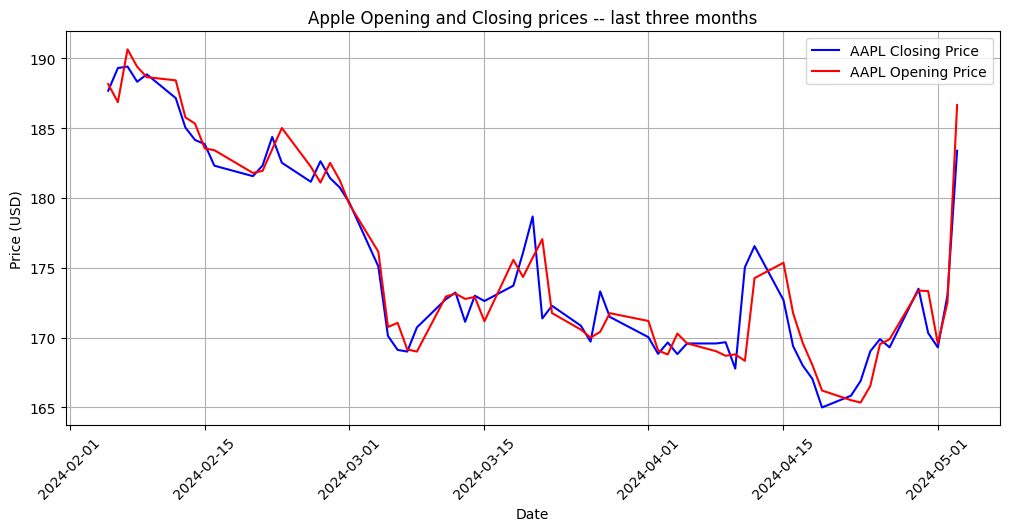

In [60]:
# Plot time series of open v. close stock price for Apple using the last 3 months of data

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pd.to_datetime(df_AAPL_last_3_months['Date'])

#opening_price = df_AAPL_last_3_months['Open']
#closing_price = df_AAPL_last_3_months['Close/Last']

plt.figure(figsize=(10,5))
#plt.plot(closing_price.index, closing_price, label="AAPL Closing Price", color = "blue")
#plt.plot(opening_price.index, opening_price, label="AAPL Opening Price", color = "red")
plt.plot(df_AAPL_last_3_months['Date'], df_AAPL_last_3_months['Close/Last'], label="AAPL Closing Price", color = "blue")
plt.plot(df_AAPL_last_3_months['Date'], df_AAPL_last_3_months['Open'], label="AAPL Opening Price", color = "red")
# Format date on x-axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.title("Apple Opening and Closing prices -- last three months")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

## EDA: Plotting a histogram of a stock's closing price in the last three months

One way to see how much a stock's price generally moves is to plot the frequency of closing prices over a set time period. 

Your task:
* Use the **last three months** of Apple stock data and plot a histogram of closing price

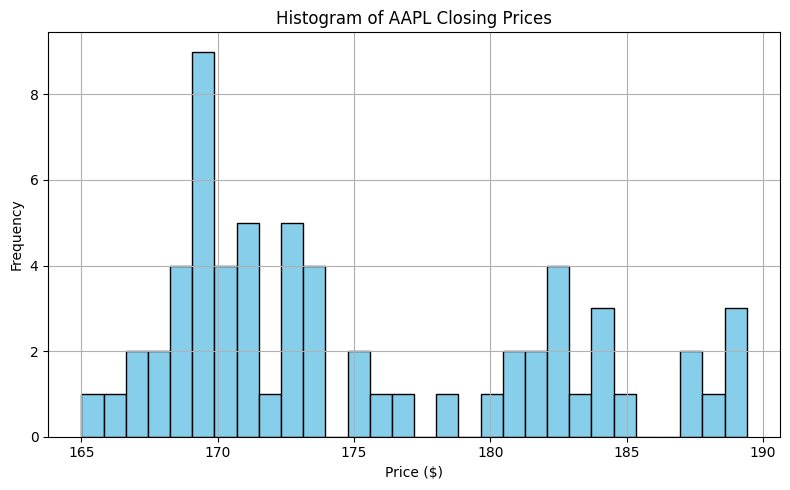

In [61]:
# Plot the histogram of Apple's closing price over the last 3 months 


plt.figure(figsize=(8, 5))
plt.hist(df_AAPL_last_3_months['Close/Last'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of AAPL Closing Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()




In [62]:
df_AAPL_last_3_months


,Date,Close/Last,Volume,Open,High,Low
2454,2024-02-05,187.68,69668820,188.15,189.25,185.84
2455,2024-02-06,189.30,43490760,186.86,189.31,186.77
2456,2024-02-07,189.41,53438960,190.64,191.05,188.61
2457,2024-02-08,188.32,40962050,189.39,189.54,187.35
2458,2024-02-09,188.85,45155220,188.65,189.99,188.00
...,...,...,...,...,...,...
2512,2024-04-29,173.50,68169420,173.37,176.03,173.10
2513,2024-04-30,170.33,65934780,173.33,174.99,170.00
2514,2024-05-01,169.30,50383150,169.58,172.71,169.11
2515,2024-05-02,173.03,94214920,172.51,173.42,170.89


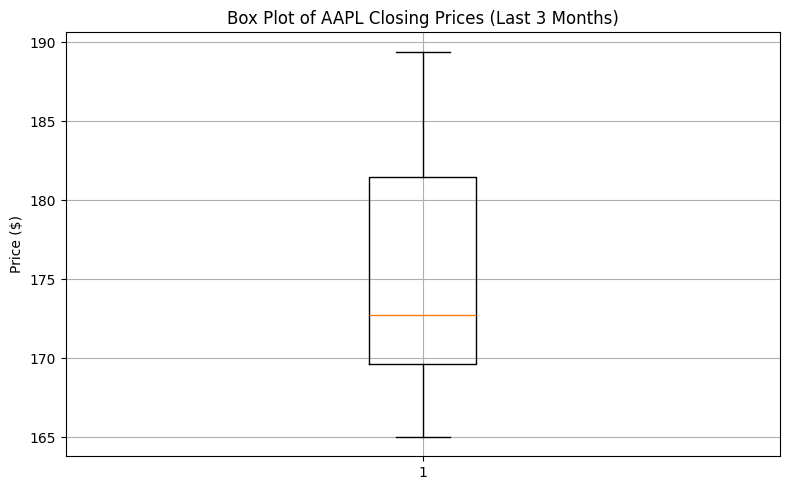

In [63]:
#comment for the teacher:
#you taught us about the Box Whisker plot, I think it makes sense to add it here.
#I hope you will appreciate the effort :-)


plt.figure(figsize=(8, 5))
plt.boxplot(df_AAPL_last_3_months['Close/Last'])
plt.title('Box Plot of AAPL Closing Prices (Last 3 Months)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

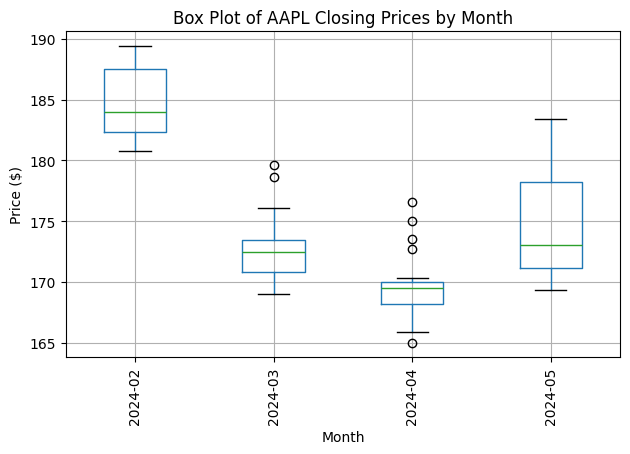

In [64]:
# Add a column for the month
#df_AAPL_last_3_months['Month'] = df_AAPL_last_3_months['Date'].dt.to_period('M').astype(str)
df_AAPL_last_3_months = df_AAPL_last_3_months.copy()
df_AAPL_last_3_months.loc[:, 'Month'] = df_AAPL_last_3_months['Date'].dt.to_period('M').astype(str)
# Boxplot grouped by month
plt.figure(figsize=(10, 6))
df_AAPL_last_3_months.boxplot(column='Close/Last', by='Month')
plt.title('Box Plot of AAPL Closing Prices by Month')
plt.suptitle('')  # Remove the automatic subtitle
plt.xlabel('Month')
plt.xticks(rotation=90)
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 5000x3500 with 0 Axes>

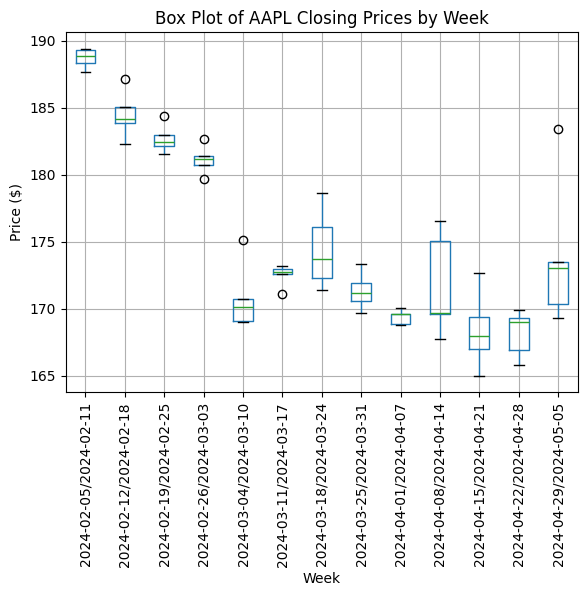

In [65]:
# Add a column for the week (year-week format)
df_AAPL_last_3_months = df_AAPL_last_3_months.copy()
df_AAPL_last_3_months.loc[:, 'Week'] = df_AAPL_last_3_months['Date'].dt.to_period('W').astype(str)
# Boxplot grouped by week
plt.figure(figsize=(50, 35))
df_AAPL_last_3_months.boxplot(column='Close/Last', by='Week')
plt.title('Box Plot of AAPL Closing Prices by Week')
plt.suptitle('')
plt.xlabel('Week')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.grid(True)
#plt.tight_layout()
plt.show()

In [66]:
df_AAPL_last_3_months #diagnostic

,Date,Close/Last,Volume,Open,High,Low,Month,Week
2454,2024-02-05,187.68,69668820,188.15,189.25,185.84,2024-02,2024-02-05/2024-02-11
2455,2024-02-06,189.30,43490760,186.86,189.31,186.77,2024-02,2024-02-05/2024-02-11
2456,2024-02-07,189.41,53438960,190.64,191.05,188.61,2024-02,2024-02-05/2024-02-11
2457,2024-02-08,188.32,40962050,189.39,189.54,187.35,2024-02,2024-02-05/2024-02-11
2458,2024-02-09,188.85,45155220,188.65,189.99,188.00,2024-02,2024-02-05/2024-02-11
...,...,...,...,...,...,...,...,...
2512,2024-04-29,173.50,68169420,173.37,176.03,173.10,2024-04,2024-04-29/2024-05-05
2513,2024-04-30,170.33,65934780,173.33,174.99,170.00,2024-04,2024-04-29/2024-05-05
2514,2024-05-01,169.30,50383150,169.58,172.71,169.11,2024-05,2024-04-29/2024-05-05
2515,2024-05-02,173.03,94214920,172.51,173.42,170.89,2024-05,2024-04-29/2024-05-05


## Calculating correlation between a stock price and a macroeconomic variable 

Inflation affects the purchasing power of money and can influence corporate profits, interest rates, and consumer behavior. By analyzing the correlation between stock prices and inflation, one can gauge how inflationary trends impact stock market performance. For instance, high inflation might erode profit margins and reduce stock prices, while moderate inflation might indicate a growing economy, benefiting stocks.

Your task:
* Plot a heatmap that shows the correlation between Microsoft and Apple returns and inflation 

This will require several steps:
1. Calculate the returns for Apple and Microsoft and the change in monthly inflation (use the `pct_change` method for each)
2. Interpolate the daily stock returns data to monthly so it can be compared to the monthly inflation data
3. Merge the stock returns (Apple and Microsoft) and inflation data series into a single dataframe
4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change
5. Plot the correlation matrix as a heatmap

In [67]:
inflation_df


,CORESTICKM159SFRBATL
DATE,
1968-01-31,3.651861
1968-02-29,3.673819
1968-03-31,4.142164
1968-04-30,4.155828
1968-05-31,4.088245
...,...
2023-11-30,4.688293
2023-12-31,4.554396
2024-01-31,4.603922


### 1. Calculate returns for Microsoft / Apple and the monthly change in inflation

In [68]:
# before I proceed to the next step, I need to fix the aapl and msft dataframes as they are ordered in the wrong order (last to first rather then first to last)

#Reset index so 'Date' becomes a column again
aapl_df = aapl_df.reset_index()
msft_df = msft_df.reset_index()

# 2. Strip column names (if needed)
#aapl_df.columns = aapl_df.columns.str.strip()
#msft_df.columns = msft_df.columns.str.strip()

# 3. Convert 'Date' to datetime
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
msft_df['Date'] = pd.to_datetime(msft_df['Date'])

# 4. Sort by 'Date' in ascending order
aapl_df = aapl_df.sort_values('Date').reset_index(drop=True)
msft_df = msft_df.sort_values('Date').reset_index(drop=True)

In [69]:
#sanity check on the order
#aapl_df
#msft_df
#msft_df.head()


In [70]:
# Calculate daily returns for Apple and Microsoft and the percent change in inflation from month to month

aapl_df['AAPL_Returns'] = aapl_df['Close/Last'].pct_change()
msft_df['MSFT_Returns'] = msft_df['Close/Last'].pct_change()
inflation_df['Inflation_Change'] = inflation_df['CORESTICKM159SFRBATL'].pct_change()


In [71]:

aapl_df.head()

,index,Date,Close/Last,Volume,Open,High,Low,AAPL_Returns
0,0,2014-05-06,21.23,373872650,21.49,21.59,21.23,NaN
1,1,2014-05-07,21.15,282128727,21.26,21.33,20.99,-0.003768
2,2,2014-05-08,21.00,228973884,21.01,21.23,20.94,-0.007092
3,3,2014-05-09,20.91,291068564,20.88,20.94,20.73,-0.004286
4,4,2014-05-12,21.17,212736019,20.98,21.20,20.98,0.012434


### 2. Interpolate stock returns from daily to monthly

In [72]:
# Ensuring appropriate indexing
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
aapl_df.set_index('Date', inplace=True)

msft_df['Date'] = pd.to_datetime(msft_df['Date'])
msft_df.set_index('Date', inplace=True)

# Resample daily returns to monthly by averaging
aapl_monthly = aapl_df['AAPL_Returns'].resample('M').mean()
msft_monthly = msft_df['MSFT_Returns'].resample('M').mean()

C:\Users\mfabr\AppData\Local\Temp\ipykernel_7912\1694970935.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aapl_monthly = aapl_df['AAPL_Returns'].resample('M').mean()
C:\Users\mfabr\AppData\Local\Temp\ipykernel_7912\1694970935.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  msft_monthly = msft_df['MSFT_Returns'].resample('M').mean()


### 3. Merge the dataframes and calculate / plot the correlation

In [73]:
# Ensure DATE is datetime and set as index
#inflation_df['DATE'] = pd.to_datetime(inflation_df['DATE'])
#inflation_df.set_index('DATE', inplace=True)

# Keep only the monthly inflation change series
inflation_monthly = inflation_df['Inflation_Change']

# Combine everything into one DataFrame
combined_df = pd.concat([aapl_monthly, msft_monthly, inflation_monthly], axis=1)
combined_df.columns = ['AAPL_Returns', 'MSFT_Returns', 'Inflation_Change']

# Drop rows with any missing values
combined_df.dropna(inplace=True)

In [74]:
combined_df

,AAPL_Returns,MSFT_Returns,Inflation_Change
2014-05-31,0.003748,0.002804,0.050251
2014-06-30,0.001328,0.000916,0.007147
2014-07-31,0.001364,0.001614,-0.020724
2014-08-31,0.003354,0.002468,-0.066387
2014-09-30,-0.000683,0.001013,-0.004516
...,...,...,...
2023-11-30,0.005122,0.005506,-0.039860
2023-12-31,0.000714,-0.000340,-0.028560
2024-01-31,-0.001941,0.002712,0.010874
2024-02-29,-0.000971,0.002056,-0.043619


### 4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change

In [75]:
# Calculate correlation matrix
correlation_matrix = combined_df.corr()
print(correlation_matrix)

                  AAPL_Returns  MSFT_Returns  Inflation_Change
AAPL_Returns          1.000000      0.581539         -0.082450
MSFT_Returns          0.581539      1.000000         -0.086133
Inflation_Change     -0.082450     -0.086133          1.000000


### 5. Plot the correlation matrix as a heatmap 

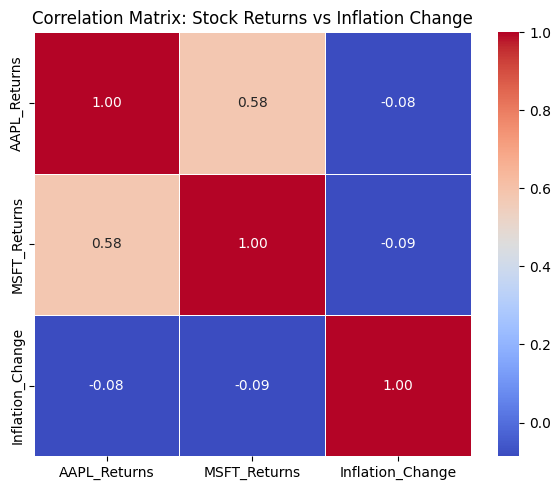

In [76]:
# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Stock Returns vs Inflation Change")
plt.tight_layout()
plt.show()


## Calculating rolling volatility (standard deviation) of a stock's price for last 3 months

Volatility is a measure of the dispersion of returns for a given security. By calculating rolling volatility, investors can assess the risk associated with a stock over time: Higher volatility indicates higher risk, as the stock's price is more likely to experience significant fluctuations. In portfolio optimization, understanding the volatility of individual stocks and how it changes over time is crucial for diversification and optimization. By analyzing rolling volatility, investors can adjust their portfolios to maintain a desired risk level, potentially improving the risk-return profile.

One possible way to calculate volatility is by using the standard deviation of returns for a stock over time.

Your task:
* Calculate the weekly rolling standard deviation for Apple's closing price
* Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price. Plot these **on the same chart, but using different y-axes**

Helpful hints:
* You'll need to use the `pandas` `rolling()` method with a given `window_size` parameter to make it a _weekly_ rolling calculation
* Use **only the last three months of data**; data much older than this may not be as useful for portfolio optimization

* You'll need to create two axes on the matplotlib figure to be able to use two different y-axes (one for the closing price and one for the rolling volatility calculated here)

In [77]:
#msft_df
#aapl_df

In [78]:
#Ensure only the last three months of data are used
#df_AAPL_3m = aapl_df[aapl_df.index > cutoff_date]
#df_MSFT_3m = msft_df[msft_df.index > cutoff_date]

#cutoff_date
#aapl_df
#msft_df
#print(aapl_df.columns)

#Calculate returns
aapl_df['AAPL_Returns'] = aapl_df['Close/Last'].pct_change()
msft_df['MSFT_Returns'] = msft_df['Close/Last'].pct_change()



In [79]:
#msft_df

In [80]:

# Define the window size for the rolling calculation (e.g., one week)
rolling_window = 5  # 5 trading days ≈ 1 week

#Calculate rolling volatility on the full dataset
aapl_df['Rolling_Volatility'] = aapl_df['AAPL_Returns'].rolling(window=rolling_window).std()
msft_df['Rolling_Volatility'] = msft_df['MSFT_Returns'].rolling(window=rolling_window).std()



In [81]:
# Calculate rolling one-week volatility
# as pointed out by the teacher, this needs to be done before chopping
# the dataframes otherwise there will be missing data.
aapl_df = aapl_df.copy() #to prevent the copy warning
aapl_df['Rolling_Volatility'] = aapl_df['AAPL_Returns'].rolling(window=rolling_window).std()
msft_df = msft_df.copy() #to prevent the copy warning
msft_df['Rolling_Volatility'] = msft_df['MSFT_Returns'].rolling(window=rolling_window).std()



In [82]:
print(cutoff_date)

df_AAPL_3m = aapl_df[aapl_df.index > cutoff_date].copy()
df_MSFT_3m = msft_df[msft_df.index > cutoff_date].copy()


2024-02-03 00:00:00


In [83]:
df_MSFT_3m

,index,Close/Last,Volume,Open,High,Low,MSFT_Returns,Rolling_Volatility
Date,,,,,,,,
2024-02-05,2454,405.65,25352290,409.90,411.1600,403.9900,-0.013545,0.019254
2024-02-06,2455,405.49,18382620,405.88,407.9700,402.9100,-0.000394,0.019255
2024-02-07,2456,414.05,22340530,407.44,414.3000,407.4000,0.021110,0.014770
2024-02-08,2457,414.11,21225260,414.05,415.5600,412.5300,0.000145,0.014459
2024-02-09,2458,420.55,22032840,415.25,420.8200,415.0900,0.015551,0.013843
...,...,...,...,...,...,...,...,...
2024-04-29,2512,402.25,19582090,405.25,406.3200,399.1900,-0.010017,0.018134
2024-04-30,2513,389.33,28781370,401.49,402.1600,389.1700,-0.032119,0.020482
2024-05-01,2514,394.94,23562480,392.61,401.7199,390.3100,0.014409,0.022592


In [84]:
df_AAPL_3m

,index,Close/Last,Volume,Open,High,Low,AAPL_Returns,Rolling_Volatility
Date,,,,,,,,
2024-02-05,2454,187.68,69668820,188.15,189.25,185.84,0.009847,0.015513
2024-02-06,2455,189.30,43490760,186.86,189.31,186.77,0.008632,0.013633
2024-02-07,2456,189.41,53438960,190.64,191.05,188.61,0.000581,0.007636
2024-02-08,2457,188.32,40962050,189.39,189.54,187.35,-0.005755,0.007444
2024-02-09,2458,188.85,45155220,188.65,189.99,188.00,0.002814,0.006342
...,...,...,...,...,...,...,...,...
2024-04-29,2512,173.50,68169420,173.37,176.03,173.10,0.024808,0.010497
2024-04-30,2513,170.33,65934780,173.33,174.99,170.00,-0.018271,0.016292
2024-05-01,2514,169.30,50383150,169.58,172.71,169.11,-0.006047,0.015996


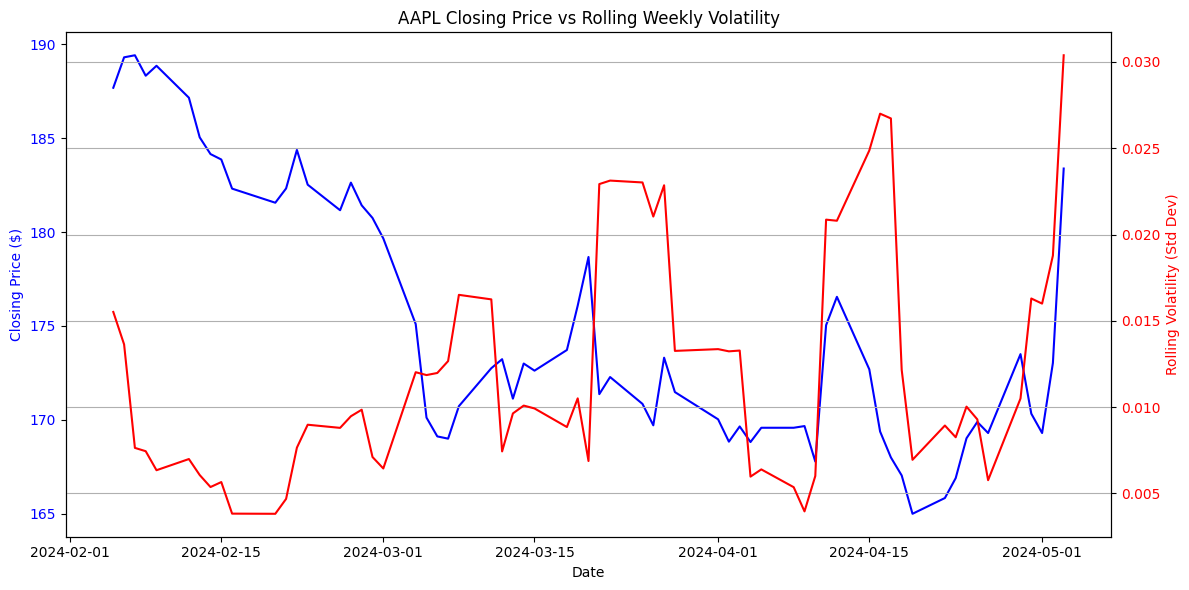

In [85]:
# Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price
# Plot these on the same chart, but using different y-axes

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# First y-axis: AAPL Closing Price
ax1.set_title("AAPL Closing Price vs Rolling Weekly Volatility")
ax1.set_xlabel("Date")
ax1.set_ylabel("Closing Price ($)", color="blue")
ax1.plot(df_AAPL_3m.index, df_AAPL_3m['Close/Last'], color="blue", label="AAPL Close")
ax1.tick_params(axis='y', labelcolor="blue")

# Second y-axis: Rolling Volatility
ax2 = ax1.twinx()
ax2.set_ylabel("Rolling Volatility (Std Dev)", color="red")
ax2.plot(df_AAPL_3m.index, df_AAPL_3m['Rolling_Volatility'], color="red", label="Weekly Volatility")
ax2.tick_params(axis='y', labelcolor="red")

# Add grid and layout
fig.tight_layout()
plt.grid(True)
plt.show()

In [86]:
#additional analyses to make the project stand out

# Additional analysis 1. Sharpe Ratio (last 3 months)
import numpy as np
risk_free_rate = 0.01  # Assume 1% annual risk-free rate

# Convert annual rate to daily (approx)
daily_rfr = (1 + risk_free_rate) ** (1/252) - 1

# Sharpe Ratio = (mean excess return) / std deviation
aapl_excess = df_AAPL_3m['AAPL_Returns'] - daily_rfr
msft_excess = df_MSFT_3m['MSFT_Returns'] - daily_rfr

sharpe_aapl = aapl_excess.mean() / aapl_excess.std()
sharpe_msft = msft_excess.mean() / msft_excess.std()
print("Sharpe Ratio AAPL (3mo):", sharpe_aapl)
print("Sharpe Ratio MSFT (3mo):", sharpe_msft)




Sharpe Ratio AAPL (3mo): -0.0090180457995589
Sharpe Ratio MSFT (3mo): -0.009769122482934321


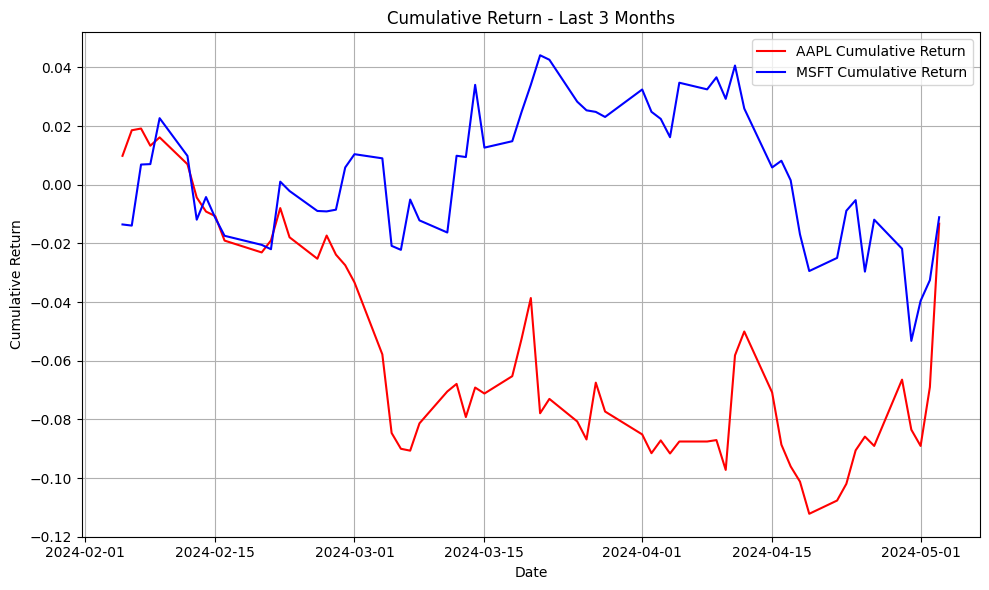

In [87]:
# Additional chart 2. Cumulative Return
aapl_cum_return = (1 + df_AAPL_3m['AAPL_Returns']).cumprod() - 1
msft_cum_return = (1 + df_MSFT_3m['MSFT_Returns']).cumprod() - 1

plt.figure(figsize=(10,6))
plt.plot(aapl_cum_return, label='AAPL Cumulative Return', color ="red")
plt.plot(msft_cum_return, label='MSFT Cumulative Return', color ="blue")
plt.title('Cumulative Return - Last 3 Months')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


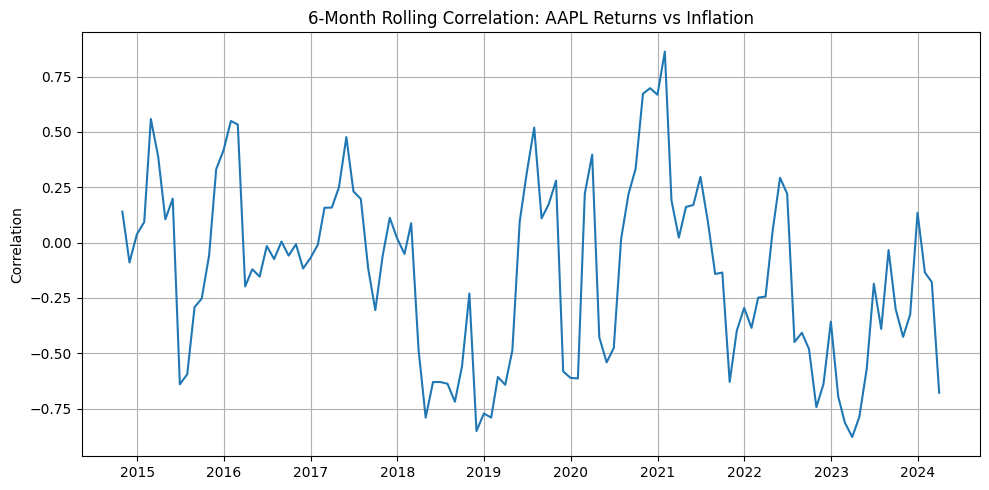

In [88]:
# Additional chart 3. Rolling Correlation (AAPL vs Inflation)
aapl_monthly_aligned = aapl_monthly[aapl_monthly.index.isin(inflation_monthly.index)]
aapl_monthly_aligned = aapl_monthly_aligned.dropna()
inflation_monthly_clean = inflation_monthly[aapl_monthly_aligned.index]
rolling_corr = aapl_monthly_aligned.rolling(6).corr(inflation_monthly_clean)

plt.figure(figsize=(10,5))
plt.plot(rolling_corr)
plt.title('6-Month Rolling Correlation: AAPL Returns vs Inflation')
plt.ylabel('Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()

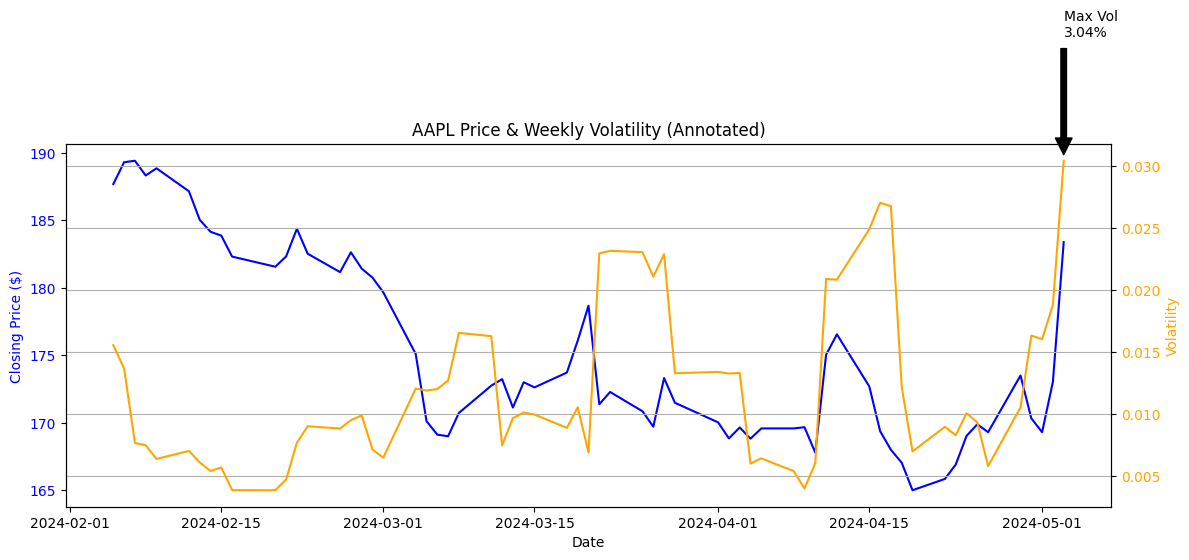

In [89]:
#Additiona chart 4. Annotated Volatility Chart
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title("AAPL Price & Weekly Volatility (Annotated)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Closing Price ($)", color="blue")
ax1.plot(df_AAPL_3m.index, df_AAPL_3m['Close/Last'], color="blue", label="AAPL Close")
ax1.tick_params(axis='y', labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Volatility", color="orange")
ax2.plot(df_AAPL_3m.index, df_AAPL_3m['Rolling_Volatility'], color="orange", label="Volatility")
ax2.tick_params(axis='y', labelcolor="orange")

# Annotate highest volatility point
max_vol_date = df_AAPL_3m['Rolling_Volatility'].idxmax()
max_vol = df_AAPL_3m['Rolling_Volatility'].max()
ax2.annotate(f"Max Vol\n{max_vol:.2%}", xy=(max_vol_date, max_vol),
             xytext=(max_vol_date, max_vol+0.01),
             arrowprops=dict(facecolor='black', shrink=0.05))

fig.tight_layout()
plt.grid(True)
plt.show()

In [90]:
!pip install plotly


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [91]:
!pip install nbformat --upgrade


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [92]:
#Additional chart 5. Interactive Plot (AAPL Price)
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'browser'

fig = px.line(df_AAPL_3m.reset_index(), x='Date', y='Close/Last', title='Interactive AAPL Closing Price (Last 3 Months)')
fig.update_traces(line=dict(color='royalblue'))
fig.show()


## Export data

Now that you have preprocessed your data, you should save it in new csv files so that it can be used in downstream tasks without having to redo all the preprocessing steps. 

Your task:
* Use `pandas` to export all modified datasets back to new CSV files

In [93]:

# Export updated DataFrames with timestamp

from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d%H%M")

print(timestamp)

aapl_df.to_csv(f'aapl_df_{timestamp}.csv')
msft_df.to_csv(f'msft_df_{timestamp}.csv')
combined_df.to_csv(f'combined_data_{timestamp}.csv')
df_AAPL_3m.to_csv(f'AAPL_last_3_months_{timestamp}.csv')
df_MSFT_3m.to_csv(f'MSFT_last_3_months_{timestamp}.csv')
df_AAPL_last_3_months.to_csv(f'AAPL_last_3_months_{timestamp}.csv')
gdp_df.to_csv(f'gdp_{timestamp}.csv')
inflation_df.to_csv(f'inflation_{timestamp}.csv')


202504061137
